In [5]:
import pickle
import numpy as np

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, Model
import numpy as np

2024-12-07 19:44:46.135635: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-07 19:44:46.188488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 19:44:46.188547: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 19:44:46.188590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 19:44:46.199035: I tensorflow/core/platform/cpu_feature_g

In [7]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.config.set_visible_devices([], 'GPU')

In [8]:
pickle_MCI_Features_file_path = r'./feature_extraction/MCI_func_features.pkl'
with open(pickle_MCI_Features_file_path, 'rb') as file:
    MCI_funct_features = pickle.load(file)
MCI_funct_features.shape
MCI_funct_features = np.array(MCI_funct_features)

In [9]:
MCI_funct_features.shape

(52, 13456)

In [10]:
pickle_MCI_Features_file_path = r'feature_extraction/cat12_MCI_structural_features.pkl'
with open(pickle_MCI_Features_file_path, 'rb') as file:
    MCI_Struct_features = pickle.load(file)
MCI_Struct_features.shape
MCI_Struct_features = np.array(MCI_Struct_features)

In [11]:
MCI_Struct_features.shape

(52, 169, 205, 169)

In [12]:
# Define the same file path
file_path = r'feature_extraction/cat12_AD_structural_features.pkl'

# Load the NumPy array from the file
with open(file_path, "rb") as file:  # 'rb' means read binary
    AD_struct_features = pickle.load(file)

print("structural_features loaded successfully!")
print("Shape of loaded array:", AD_struct_features.shape)


structural_features loaded successfully!
Shape of loaded array: (40, 169, 205, 169)


In [13]:
pickle_AD_Features_file_path = r"feature_extraction/AD_func_features.pkl"
with open(pickle_AD_Features_file_path, 'rb') as file:
    AD_funct_features = pickle.load(file)
AD_funct_features = np.array(AD_funct_features)
AD_funct_features.shape

(40, 13456)

In [14]:
# Define the same file path
file_path = r'feature_extraction/cat12_CN_structural_features.pkl'

# Load the NumPy array from the file
with open(file_path, "rb") as file:  # 'rb' means read binary
    CN_struct_features = pickle.load(file)

print("structural_features loaded successfully!")
print("Shape of loaded array:", CN_struct_features.shape)

structural_features loaded successfully!
Shape of loaded array: (30, 169, 205, 169)


In [15]:
pickle_AD_Features_file_path = r"feature_extraction/CN_func_features.pkl"
with open(pickle_AD_Features_file_path, 'rb') as file:
    CN_funct_features = pickle.load(file)
CN_funct_features.shape

(30, 13456)

In [16]:
MCI_funct_features.shape, MCI_Struct_features.shape

((52, 13456), (52, 169, 205, 169))

In [17]:
AD_funct_features.shape, AD_struct_features.shape

((40, 13456), (40, 169, 205, 169))

In [18]:
CN_funct_features.shape, CN_struct_features.shape

((30, 13456), (30, 169, 205, 169))

In [19]:

# Data Shapes
AD_Struct_features = AD_struct_features
# Labels
MCI_labels = np.zeros(MCI_funct_features.shape[0])  # Label 0 for MCI
AD_labels = np.ones(AD_funct_features.shape[0])    # Label 1 for AD
CN_labels = np.array([2]*CN_funct_features.shape[0])

# Combine functional and structural features
funct_features = np.vstack((MCI_funct_features, AD_funct_features, CN_funct_features))
struct_features = np.vstack((MCI_Struct_features, AD_Struct_features, CN_struct_features))
labels = np.hstack((MCI_labels, AD_labels, CN_labels))

In [20]:
struct_features = np.expand_dims(struct_features, axis=-1)

In [21]:
funct_features = funct_features.reshape(-1, 116, 116)
funct_features = np.expand_dims(funct_features, axis=-1)
funct_features.shape

(122, 116, 116, 1)

In [ ]:
funct_features = np.random.rand(15, 116, 116, 1)
struct_features = np.random.rand(15, 169, 205, 169)
labels = np.array([0]*5 + [1]*5 + [2]*5) 

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
# Split data into training and testing sets
X_train_3d, X_test_3d, X_train_2d, X_test_2d, y_train, y_test = train_test_split(
    struct_features,
    funct_features,
    labels,
    test_size=0.2,
    random_state=42
)

In [24]:
# Discriminator labels (real images are labeled as 1)
real_labels_train = np.ones((X_train_3d.shape[0], 1))
real_labels_test = np.ones((X_test_3d.shape[0], 1))

# For simplicity, use real labels for reconstructed images
disc_targets_3d_train = real_labels_train
disc_targets_2d_train = real_labels_train

disc_targets_3d_test = real_labels_test
disc_targets_2d_test = real_labels_test

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def build_encoder_3d_2d(input_shape):
    inputs = Input(shape=input_shape) # 169x205 x169 (input, 169 channels)
    x = layers.Conv2D(32, (3, 3), activation='gelu', padding='valid')(inputs) # 166×203 ×32
    x = layers.MaxPooling2D((2, 2))(x) # 83×101×83 x32
    x = layers.Conv2D(64, (3, 3), activation='gelu', padding='valid')(x) # 81×99 x64
    x = layers.MaxPooling2D((2, 2))(x) # 40×49×40 x64
    x = layers.Conv2D(128, (3, 3), activation='gelu', padding='valid')(x) # 38×47 x128
    x = layers.Flatten()(x)
    latent = layers.Dense(256, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    encoder = Model(inputs, latent, name='encoder_3d')
    return encoder

In [26]:
def build_encoder_2d(input_shape):
    inputs = Input(shape=input_shape) # 116x116 x1
    x = layers.Conv2D(32, (3, 3), activation='gelu', padding='valid')(inputs) # 114x114 x32
    x = layers.MaxPooling2D((2, 2))(x) # 57x57 x32
    x = layers.Conv2D(64, (3, 3), activation='gelu', padding='valid')(x) # 55x55 x64
    x = layers.MaxPooling2D((2, 2))(x) # 27x27 x64
    x = layers.Conv2D(128, (3, 3), activation='gelu', padding='valid')(x) # 25x25 x128
    x = layers.Flatten()(x)
    latent = layers.Dense(256, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    encoder = Model(inputs, latent, name='encoder_2d')
    return encoder

In [27]:
def build_decoder_3d_2d(latent_dim, output_shape):
    # output_shape: (height, width, channels) - Original 2D data shape with high number of channels
    height, width, channels = output_shape[0], output_shape[1], output_shape[2]
    
    latent_inputs = Input(shape=(latent_dim,))
    
    # Define the dimensions to reshape the latent vector
    reshape_height = height // 8
    reshape_width = width // 8
    reshape_filters = 128  # Number of filters
    
    x = layers.Dense(reshape_height * reshape_width * reshape_filters, activation='gelu')(latent_inputs)
    x = layers.Reshape((reshape_height, reshape_width, reshape_filters))(x)
    
    # Upsample spatial dimensions
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='gelu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='gelu')(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='gelu')(x)
    
    # Final layer to match the number of channels
    x = layers.ZeroPadding2D(padding=((0, 1), (0, 5)))(x)
    outputs = layers.Conv2DTranspose(channels, (3, 3), padding='same', activation='sigmoid')(x)
    assert outputs.shape[1:] == output_shape, f"Expected output shape {output_shape} but got {outputs.shape[1:]}"
    decoder = Model(latent_inputs, outputs, name='decoder_3d')
    return decoder

In [28]:
def build_decoder_2d(latent_dim, output_shape):
    latent_inputs = Input(shape=(latent_dim,))
    x = layers.Dense((output_shape[0]//4)*(output_shape[1]//4)*64, activation='gelu')(latent_inputs)
    x = layers.Reshape((output_shape[0]//4, output_shape[1]//4, 64))(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='valid', activation='gelu')(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='valid', activation='gelu')(x)
    x = layers.Conv2DTranspose(1, (3, 3), padding='valid', activation='sigmoid')(x)
    outputs = layers.Cropping2D(cropping=((2, 3), (2, 3)))(x) 

    assert outputs.shape[1:-1] == output_shape, f"Output shape {outputs.shape[1:-1]} does not match expected shape {output_shape}"


    decoder = Model(latent_inputs, outputs, name='decoder_2d')
    return decoder

In [29]:
def build_discriminator_3d_2d(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='gelu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='gelu')(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    discriminator = Model(inputs, outputs, name='discriminator_3d')
    return discriminator

In [30]:
def build_discriminator_2d(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='gelu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='gelu')(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    discriminator = Model(inputs, outputs, name='discriminator_2d')
    return discriminator

In [31]:
def build_classifier(input_dim, num_classes):
    inputs = Input(shape=(input_dim,))
    # x = layers.Dense(256, activation='gelu')(inputs)
    x = layers.Dense(128, activation='gelu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    classifier = Model(inputs, outputs, name='classifier')
    return classifier

In [32]:
# Input shapes
input_shape_3d = (169, 205, 169)
input_shape_2d = (116, 116, 1)
latent_dim = 256
num_classes = 3

# Build models
encoder_3d = build_encoder_3d_2d(input_shape_3d)
encoder_2d = build_encoder_2d(input_shape_2d)
decoder_3d = build_decoder_3d_2d(latent_dim, input_shape_3d)
decoder_2d = build_decoder_2d(latent_dim, input_shape_2d[:-1])
discriminator_3d = build_discriminator_3d_2d(input_shape_3d)
discriminator_2d = build_discriminator_2d(input_shape_2d)
# Build classifier that accepts concatenated latent vectors
classifier = build_classifier(latent_dim * 2, num_classes)

# Inputs
input_3d = Input(shape=input_shape_3d)
input_2d = Input(shape=input_shape_2d)

# Encoding
latent_3d = encoder_3d(input_3d)
latent_2d = encoder_2d(input_2d)

# Concatenate the two latent representations
combined_latent = layers.Concatenate()([latent_3d, latent_2d])

# Decoding
reconstructed_3d = decoder_3d(latent_3d)
reconstructed_2d = decoder_2d(latent_2d)

# Discriminator outputs
disc_output_3d = discriminator_3d(reconstructed_3d)
disc_output_2d = discriminator_2d(reconstructed_2d)

# Get classification output
classification_output = classifier(combined_latent)

# Define the combined model
model = Model(
    inputs=[input_3d, input_2d],
    outputs=[
        reconstructed_3d,
        reconstructed_2d,
        disc_output_3d,
        disc_output_2d,
        classification_output
    ]
)

2024-12-07 19:45:22.604969: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 45738 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6


In [33]:
# Loss weights
lambda_reconstruction = 1.0
lambda_adversarial = 0.1
lambda_classification = 1.0

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'decoder_3d': 'mse',
        'decoder_2d': 'mse',
        'discriminator_3d': tf.keras.losses.BinaryCrossentropy(),
        'discriminator_2d': tf.keras.losses.BinaryCrossentropy(),
        'classifier': 'sparse_categorical_crossentropy'
    },
    loss_weights={
        'decoder_3d': lambda_reconstruction,
        'decoder_2d': lambda_reconstruction,
        'discriminator_3d': lambda_adversarial,
        'discriminator_2d': lambda_adversarial,
        'classifier': lambda_classification
    },
    metrics={
        'classifier': 'accuracy'
    }
)

In [34]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)


# Discriminator labels (real images are labeled as 1)
real_labels = np.ones((struct_features.shape[0], 1))
fake_labels = np.zeros((struct_features.shape[0], 1))

# For simplicity, use real labels for reconstructed images (you can adjust as needed)
disc_targets_3d = real_labels
disc_targets_2d = real_labels


# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}


In [35]:
# Train the model
history = model.fit(
    [X_train_3d, X_train_2d],
    {
        'decoder_3d': X_train_3d,
        'decoder_2d': X_train_2d,
        'discriminator_3d': disc_targets_3d_train,
        'discriminator_2d': disc_targets_2d_train,
        'classifier': y_train
    },
    epochs=20,
    batch_size=8,
    validation_data=(
        [X_test_3d, X_test_2d],
        {
            'decoder_3d': X_test_3d,
            'decoder_2d': X_test_2d,
            'discriminator_3d': disc_targets_3d_test,
            'discriminator_2d': disc_targets_2d_test,
            'classifier': y_test
        }
    ),
    # class_weight=class_weights,
    callbacks=[lr_scheduler]
)

Epoch 1/20


2024-12-07 19:45:46.300200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-12-07 19:45:48.131531: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x71c52c098b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-07 19:45:48.131595: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-12-07 19:45:48.153223: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-07 19:45:48.291182: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - 17s 578ms/step - loss: 4.8187 - decoder_3d_loss: 0.1945 - decoder_2d_loss: 0.0659 - discriminator_3d_loss: 0.0803 - discriminator_2d_loss: 0.0607 - classifier_loss: 4.5272 - classifier_accuracy: 0.3299 - val_loss: 4.3283 - val_decoder_3d_loss: 0.1922 - val_decoder_2d_loss: 0.0560 - val_discriminator_3d_loss: 0.0000e+00 - val_discriminator_2d_loss: 1.3922e-18 - val_classifier_loss: 4.0562 - val_classifier_accuracy: 0.4800 - lr: 0.0010
Epoch 2/20
13/13 [==============================] - 2s 175ms/step - loss: 2.7325 - decoder_3d_loss: 0.1617 - decoder_2d_loss: 0.0506 - discriminator_3d_loss: 0.0000e+00 - discriminator_2d_loss: 1.6636e-19 - classifier_loss: 2.4919 - classifier_accuracy: 0.3918 - val_loss: 1.7692 - val_decoder_3d_loss: 0.0862 - val_decoder_2d_loss: 0.0499 - val_discriminator_3d_loss: 0.0000e+00 - val_discriminator_2d_loss: 2.4431e-22 - val_classifier_loss: 1.6001 - val_classifier_accuracy: 0.2000 - lr: 0.0010
Epoch 3/20
13/13 [======

In [36]:
# Evaluate the classifier accuracy on the test set
evaluation = model.evaluate(
    [X_test_3d, X_test_2d],
    {
        'decoder_3d': X_test_3d,
        'decoder_2d': X_test_2d,
        'discriminator_3d': disc_targets_3d_test,
        'discriminator_2d': disc_targets_2d_test,
        'classifier': y_test
    },
    verbose=0
)

# Get the index of the classification loss and accuracy (depends on the order of outputs)
classification_accuracy = evaluation[model.metrics_names.index('classifier_accuracy')]

print(f'Classifier Test Accuracy: {classification_accuracy * 100:.2f}%')

Classifier Test Accuracy: 64.00%


In [37]:
evaluation_train = model.evaluate(
    [X_train_3d, X_train_2d],
    {
        'decoder_3d': X_train_3d,
        'decoder_2d': X_train_2d,
        'discriminator_3d': disc_targets_3d_train,
        'discriminator_2d': disc_targets_2d_train,
        'classifier': y_train
    },
    verbose=0
)

classification_accuracy = evaluation_train[model.metrics_names.index('classifier_accuracy')]

print(f'Classifier Train Accuracy : {classification_accuracy * 100:.2f}')

Classifier Train Accuracy : 95.88


In [ ]:
model.predict()

In [36]:
model.save("models/fusion_model_1.h5")

/home/tripti/miniconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


OSError: [Errno 28] Can't close file (file write failed: time = Thu Nov 28 18:09:47 2024
, filename = 'models/fusion_model_1.h5', file descriptor = 84, errno = 28, error message = 'No space left on device', buf = 0xbfd3120, total write size = 47824, bytes this sub-write = 47824, bytes actually written = 18446744073709551615, offset = 0)

In [33]:
X_train_3d.shape, X_test_2d.shape

((97, 169, 205, 169), (25, 116, 116, 1))

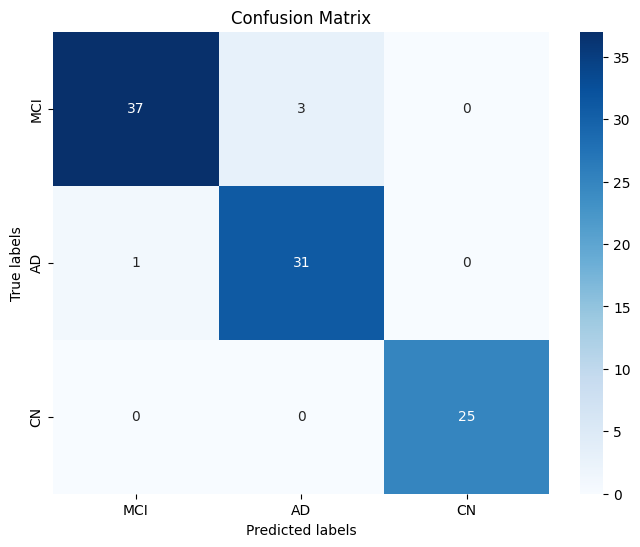

In [50]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names = ['MCI', 'AD', 'CN']

# Predict the labels for the test set using the classifier part of your model
y_pred_probs = model.predict([X_train_3d, X_train_2d], verbose=0)
y_pred = np.argmax(y_pred_probs[4], axis=-1)  # assuming classifier output is in the last dimension

# Calculate the confusion matrix
cm = confusion_matrix(y_train, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [49]:
y_pred_probs[4]

array([[9.16938663e-01, 3.52988653e-02, 4.77625392e-02],
       [2.44880226e-02, 1.30234903e-03, 9.74209607e-01],
       [2.57949889e-01, 1.08489856e-01, 6.33560300e-01],
       [9.94616807e-01, 3.97935649e-03, 1.40383479e-03],
       [1.04013219e-01, 2.44539790e-02, 8.71532798e-01],
       [9.11501944e-01, 8.54376145e-03, 7.99542218e-02],
       [6.95240557e-01, 2.26158779e-02, 2.82143503e-01],
       [8.72728508e-03, 9.89578187e-01, 1.69443851e-03],
       [8.56403172e-01, 1.31570056e-01, 1.20267635e-02],
       [8.92379284e-02, 5.64928586e-03, 9.05112803e-01],
       [1.76591545e-01, 7.91103542e-01, 3.23048905e-02],
       [1.51706919e-01, 8.44807506e-01, 3.48564214e-03],
       [9.96385336e-01, 2.55420618e-03, 1.06041541e-03],
       [3.70892044e-03, 9.96122658e-01, 1.68418454e-04],
       [1.50781181e-02, 9.83923137e-01, 9.98779666e-04],
       [7.21028805e-01, 2.78501689e-01, 4.69471270e-04],
       [9.99754608e-01, 5.57318162e-05, 1.89584403e-04],
       [9.61203218e-01, 3.64660